**Imports des données**

In [10]:
import numpy as np
import json
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

filename_path = 'data/df.csv'
df = pd.read_csv(filename_path)

**Parametres divers**

In [11]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 100)

**Fonctions utilisateurs**

In [12]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_tweedie_deviance

def get_errors(y_true,y_pred):    
    errors = y_pred-y_true
    errors_absolute = np.abs(errors)
    errors_relative= errors_absolute/np.abs(y_true)
    errors_normalized = errors/np.mean(y_true)

    data = {'y_true' : y_true ,
            'y_pred' : y_pred ,
            'errors' : errors,
            'errors_abs' : errors_absolute,
            'errors_normalized' : errors_normalized,
            'errors_relative' : errors_relative}
    
    return pd.DataFrame(data)

def get_metrics(y_true, y_pred, index , decimals=3):
    
    """
    Calcul de toutes les métriques de Regression
    

            Parameters
            ----------
            
            y_true : array-like
                valeurs observées
            y_pred : array-like
                valeurs prédites
            index : string
                nom/valeur de l'index
            decimals: number
                valeur de précision d'arrondissement des metriques

            Returns
            ----------
            
            metrics : DataFrame
                Renvoie les metriques de régression

    """  
    dict_metrics = {}
    
    results = get_errors(y_true,y_pred)
    df = results.describe(percentiles=[0.05, 0.25,0.50, 0.75, 0.95])
    
    dict_metrics["Min"]=df.loc["min","errors_relative"]
    dict_metrics["5%"]=df.loc["5%","errors_relative"]
    dict_metrics["25%"]=df.loc["25%","errors_relative"]
    dict_metrics["50%"]=df.loc["50%","errors_relative"]
    dict_metrics["75%"]=df.loc["75%","errors_relative"]
    dict_metrics["95%"]=df.loc["95%","errors_relative"]
    dict_metrics["Max"]=df.loc["max","errors_relative"]    
    
    #dict_metrics['explained_variance_score']=explained_variance_score(y_true,y_pred)
    #dict_metrics['max_error']=max_error(y_true,y_pred)
    #dict_metrics['mean_absolute_error']=mean_absolute_error(y_true,y_pred)
    #dict_metrics['normalized_mean_absolute_error']=mean_absolute_error(y_true,y_pred)/np.mean(y_true)
    #dict_metrics['mean_squared_error']=mean_squared_error(y_true,y_pred)
    dict_metrics['root_mean_squared_error']=mean_squared_error(y_true,y_pred,squared=False)
    #dict_metrics['normalized_root_mean_squared_error']=mean_squared_error(y_true,y_pred,squared=False)/np.mean(y_true)
    #dict_metrics['median_absolute_error']=median_absolute_error(y_true,y_pred)
    #dict_metrics['normalized_median_absolute_error']=median_absolute_error(y_true,y_pred)/np.mean(y_true)
    dict_metrics['r2_score']=r2_score(y_true,y_pred)
    #dict_metrics['mean_squared_log_error']=mean_squared_log_error(y_true,y_pred)
    #dict_metrics['mean_poisson_deviance']=mean_poisson_deviance(y_true,y_pred)
    #dict_metrics['mean_gamma_deviance']=mean_gamma_deviance(y_true,y_pred)
    #dict_metrics['mean_tweedie_deviance']=mean_tweedie_deviance(y_true,y_pred)
    
    metrics = pd.DataFrame(dict_metrics, index=[index])
    
    return metrics.round(decimals)

In [13]:
from math import ceil,sqrt,floor

def get_colors_from_listedcolormap(colormap, x):
        
    """
    Retourne un nombre x de couleurs avec un espacement homogene contenus dans une colormap
    
    """
    colors = []
    for i in range(0,x):
        if x <2:
            y=1
        else:
            y=i/(x-1)
        colors.append(COLORMAP.colors[floor((COLORMAP.N-1)*y)])
    return colors

#Mes couleurs
COLORMAP = sns.color_palette("plasma", as_cmap=True)
COLORS = get_colors_from_listedcolormap(COLORMAP,5)
COLOR_PRIMARY = COLORS[0]
COLOR_SECONDARY = COLORS[1]
COLOR_TERTIARY = COLORS[4]
COLOR_QUATERNARY = COLORS[2]
COLOR_QUINARY = COLORS[3]

**Choix des prédicteurs**   

In [14]:
all_columns = [
    'BuildingType',
    'PrimaryPropertyType',
    'CouncilDistrictCode',
    'Neighborhood',
    'YearBuilt',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'LargestPropertyUseType',
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA',
    'SiteEnergyUseWN(kBtu)',
    'GHGEmissions(MetricTonsCO2e)',
    'ENERGYSTARScore']

In [15]:
predicators_columns = [
    'CouncilDistrictCode',
    'YearBuilt',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA',
    'PrimaryPropertyType',
    'CouncilDistrictCode',
    'Neighborhood']

target_columns = [
    'SiteEnergyUseWN(kBtu)','GHGEmissions(MetricTonsCO2e)']

In [16]:
#only for test energyscore => drop to 4802
df= df.dropna()

In [17]:
X = df.loc[:, predicators_columns]
y = df.loc[:, target_columns[0]]

In [18]:
X.shape

(4802, 13)

**Pré-traitement**
_______________________________

**Détection des valeurs aberrantes ( Outlier Detection )**

In [19]:
#Ne pas utiliser dans le cadre de ce projet
"""from sklearn.neighbors import LocalOutlierFactor

local_outlier_factor = LocalOutlierFactor(n_neighbors=20, contamination=0.01)

labels = local_outlier_factor.fit_predict(X.select_dtypes(include=[np.number]))

print(f'Nombre d\'outliers : {np.count_nonzero(labels == -1)}')
print(f'Nombre d\'inliers : {np.count_nonzero(labels == 1)}')

X = X[labels == 1]
y = y[labels == 1]"""

"from sklearn.neighbors import LocalOutlierFactor\n\nlocal_outlier_factor = LocalOutlierFactor(n_neighbors=20, contamination=0.01)\n\nlabels = local_outlier_factor.fit_predict(X.select_dtypes(include=[np.number]))\n\nprint(f'Nombre d'outliers : {np.count_nonzero(labels == -1)}')\nprint(f'Nombre d'inliers : {np.count_nonzero(labels == 1)}')\n\nX = X[labels == 1]\ny = y[labels == 1]"

In [20]:
X.shape

(4802, 13)

**Transformation : encodage des catégories et mise à l'échelle des valeurs numériques**

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

X_categorical = X.select_dtypes(exclude=[np.number]).reset_index(drop=True)
X_numerical = X.select_dtypes(include=[np.number]).reset_index(drop=True)

one_hot_encoder = OneHotEncoder(sparse=False)
X_categorical = one_hot_encoder.fit_transform(X_categorical)
X_categorical = pd.DataFrame(X_categorical, columns=one_hot_encoder.get_feature_names().ravel())

columns= X_numerical.columns
standard_scaler_X = StandardScaler().fit(X_numerical)
X_numerical = standard_scaler_X.transform(X_numerical)
X_numerical = pd.DataFrame(X_numerical, columns=columns)


X = X_numerical.join(X_categorical)

In [22]:
X.sample(10)

,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,...,x1_Downtown,x1_East,x1_Greater duwamish,x1_Lake union,x1_Magnolia / queen anne,x1_North,x1_Northeast,x1_Northwest,x1_Southeast,x1_Southwest
346,1.207991,-2.174396,-0.085294,0.160746,-0.254223,-0.292854,-0.216447,-0.273148,-0.084453,-0.136023,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4142,1.207991,0.605418,-0.085294,-0.173628,-0.438836,-0.158447,-0.465886,-0.447963,-0.235984,-0.136023,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3624,-1.661074,0.574184,-0.085294,-0.173628,-0.469599,-0.292854,-0.465769,-0.447840,-0.353397,-0.136023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1898,0.251636,0.074442,-0.085294,-0.675188,-0.438029,-0.292854,-0.429223,-0.445469,-0.353397,-0.136023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1293,1.207991,-0.362832,-0.085294,0.160746,-0.371966,-0.292854,-0.352748,-0.328849,-0.353397,-0.136023,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3038,-0.226542,0.917757,-0.085294,-0.340815,0.356731,1.344014,0.055696,0.101174,-0.353397,-0.136023,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3960,0.251636,-0.643937,-0.085294,-0.508002,-0.342120,-0.292854,-0.318198,-0.347000,-0.353397,-0.136023,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4175,-0.704719,-1.737122,-0.085294,-0.173628,-0.495069,-0.292854,-0.495254,-0.478883,-0.353397,-0.136023,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2721,-0.226542,1.136394,-0.085294,-0.340815,0.052725,0.951524,-0.191896,0.036332,0.122378,-0.136023,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
366,1.207991,-2.018227,-0.085294,0.160746,0.494194,-0.292854,0.649932,0.255056,0.153780,-0.080778,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


___
### Séparation du jeu de données
___

In [23]:
from sklearn.model_selection import train_test_split
random_state=99
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=random_state)

___
### Modélisation et optimisation principale
Mise en place de la validation croisée et d'une méthode d'optimisation à l'aide d'une grille paramétrable
___


In [24]:
scoring='neg_root_mean_squared_error'

**0) régression baseline**

In [25]:
from sklearn.dummy import DummyRegressor

dummy_regression = DummyRegressor(strategy="mean")
dummy_regression.fit(X_train,y_train)

y_pred_val = dummy_regression.predict(X_val)

In [26]:
regression_report = get_metrics(y_val, y_pred_val, 'dummy_regression_on_val')

In [27]:
y_pred_train = dummy_regression.predict(X_train)
regression_report = regression_report.append(get_metrics(y_train, y_pred_train, 'dummy_regression_on_train'))

**1) régression linéaire multiple**

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

linear_regression = LinearRegression()

hyperparameters = dict()

gscv_linear_regression = GridSearchCV(linear_regression, hyperparameters, cv=KFold(5,shuffle=True, random_state=random_state), scoring=scoring)

gscv_linear_regression.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=99, shuffle=True),
             estimator=LinearRegression(), param_grid={},
             scoring='neg_root_mean_squared_error')

In [29]:
y_pred_train = gscv_linear_regression.predict(X_train)
regression_report = regression_report.append(get_metrics(y_train, y_pred_train, 'linear_regression_on_train'))

In [30]:
y_pred_val = gscv_linear_regression.predict(X_val)
regression_report = regression_report.append(get_metrics(y_val, y_pred_val, 'linear_regression_on_val'))

**2) régression ridge**

In [31]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge_regression = Ridge()

n_alphas = 100
alpha = np.logspace(-2, 8, n_alphas)

hyperparameters = dict(alpha=alpha)

gscv_ridge_regression = GridSearchCV(ridge_regression, hyperparameters, cv=KFold(5,shuffle=True, random_state=random_state), scoring=scoring)

gscv_ridge_regression.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=99, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-02, 1.26185688e-02, 1.59228279e-02, 2.00923300e-02,
       2.53536449e-02, 3.19926714e-02, 4.03701726e-02, 5.09413801e-02,
       6.42807312e-02, 8.11130831e-02, 1.02353102e-01, 1.29154967e-01,
       1.62975083e-01, 2.05651231e-01, 2.59502421e-01, 3.27454916e-01,
       4....
       4.75081016e+05, 5.99484250e+05, 7.56463328e+05, 9.54548457e+05,
       1.20450354e+06, 1.51991108e+06, 1.91791026e+06, 2.42012826e+06,
       3.05385551e+06, 3.85352859e+06, 4.86260158e+06, 6.13590727e+06,
       7.74263683e+06, 9.77009957e+06, 1.23284674e+07, 1.55567614e+07,
       1.96304065e+07, 2.47707636e+07, 3.12571585e+07, 3.94420606e+07,
       4.97702356e+07, 6.28029144e+07, 7.92482898e+07, 1.00000000e+08])},
             scoring='neg_root_mean_squared_error')

In [32]:
print('coefficients: ', gscv_ridge_regression.best_estimator_.coef_.flatten())
print('alpha: ', gscv_ridge_regression.best_estimator_.get_params()['alpha'])
print('score moyen sur cv: ', gscv_ridge_regression.best_score_)

y_pred_val = gscv_ridge_regression.predict(X_val)
regression_report = regression_report.append(get_metrics(y_val, y_pred_val, 'gscv_ridge_regression_on_val'))

coefficients:  [ 5.92272360e+04 -2.46702344e+05  4.68152037e+05 -4.74473022e+05
 -3.73965891e+06 -2.70835307e+06 -3.60915990e+06  1.41808221e+07
  3.79378684e+06  4.28242907e+06  5.92272360e+04 -5.56424926e+06
 -6.00490010e+06 -6.71241880e+06  6.28298294e+07 -4.63077851e+05
 -5.85446968e+06 -6.76697754e+06 -5.70498300e+06  1.58094533e+06
 -6.41331708e+06 -5.92631587e+06 -6.62894032e+06 -1.88156358e+06
  2.37849185e+07 -3.91444512e+06 -5.11465211e+06 -4.36276561e+06
 -4.32601256e+06 -2.48857430e+05 -3.17175030e+06 -4.49663185e+06
  3.58137221e+06  3.35414308e+06 -6.68748044e+06 -4.88740006e+06
 -7.82272286e+05  3.40748020e+05  1.49419400e+05  1.64184179e+05
  1.41782103e+06  2.49637487e+05  6.29222092e+04  1.00138307e+05
 -6.03396363e+05  7.63616276e+05 -1.09004393e+06 -9.67006750e+05
  1.94232422e+05]
alpha:  4.229242874389499
score moyen sur cv:  -11231461.158312073


In [33]:
y_pred_train = gscv_ridge_regression.predict(X_train)
regression_report = regression_report.append(get_metrics(y_train, y_pred_train, 'gscv_ridge_regression_on_train'))

**3) régression lasso**

In [34]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso_regression = Lasso()

n_alphas = 100
alpha = np.logspace(-2, 8, n_alphas)
max_iter = [10000]

hyperparameters = dict(alpha=alpha, max_iter=max_iter)

gscv_lasso_regression = GridSearchCV(lasso_regression, hyperparameters, cv=KFold(5,shuffle=True, random_state=random_state), scoring=scoring)

gscv_lasso_regression.fit(X_train,y_train)

C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5386703161529056e+16, tolerance: 100193543651837.31
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.036982018940672e+16, tolerance: 62604275744005.766
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2570765808006912e+16, tolerance: 79529678805547.22
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: C

C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1519729982768512e+16, tolerance: 84811843270307.72
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3080669845131744e+16, tolerance: 88939676027118.1
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.53867127808784e+16, tolerance: 100193543651837.31
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0369846982675072e+16, tolerance: 62604275744005.766
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2570796878822656e+16, tolerance: 79529678805547.22
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1519753600275712e+16, tolerance: 84811843270307.72
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: C

C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3080777926891616e+16, tolerance: 88939676027118.1
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5386854648858976e+16, tolerance: 100193543651837.31
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0369941426067104e+16, tolerance: 62604275744005.766
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: C

C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4823557545574816.0, tolerance: 79529678805547.22
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1520136270386304e+16, tolerance: 84811843270307.72
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3081134115442016e+16, tolerance: 88939676027118.1
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5388652381217248e+16, tolerance: 100193543651837.31
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.03714169459976e+16, tolerance: 62604275744005.766
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1470336737575360.0, tolerance: 79529678805547.22
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1526400523454976e+16, tolerance: 84811843270307.72
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3088392900677984e+16, tolerance: 88939676027118.1
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5396466108396864e+16, tolerance: 100193543651837.31
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

GridSearchCV(cv=KFold(n_splits=5, random_state=99, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-02, 1.26185688e-02, 1.59228279e-02, 2.00923300e-02,
       2.53536449e-02, 3.19926714e-02, 4.03701726e-02, 5.09413801e-02,
       6.42807312e-02, 8.11130831e-02, 1.02353102e-01, 1.29154967e-01,
       1.62975083e-01, 2.05651231e-01, 2.59502421e-01, 3.27454916e-01,
       4....
       1.20450354e+06, 1.51991108e+06, 1.91791026e+06, 2.42012826e+06,
       3.05385551e+06, 3.85352859e+06, 4.86260158e+06, 6.13590727e+06,
       7.74263683e+06, 9.77009957e+06, 1.23284674e+07, 1.55567614e+07,
       1.96304065e+07, 2.47707636e+07, 3.12571585e+07, 3.94420606e+07,
       4.97702356e+07, 6.28029144e+07, 7.92482898e+07, 1.00000000e+08]),
                         'max_iter': [10000]},
             scoring='neg_root_mean_squared_error')

In [35]:
print('coefficients: ', gscv_lasso_regression.best_estimator_.coef_.flatten())
print('alpha: ', gscv_lasso_regression.best_estimator_.get_params()['alpha'])
print('score moyen sur cv: ', gscv_lasso_regression.best_score_)

y_pred_val = gscv_lasso_regression.predict(X_val)
regression_report = regression_report.append(get_metrics(y_val, y_pred_val, 'gscv_lasso_regression_on_val'))

coefficients:  [ 0.00000000e+00 -3.16099310e+05  3.47131491e+05 -3.97170363e+05
 -6.74092148e+06 -1.62143613e+06 -0.00000000e+00  1.28398309e+07
  3.54220912e+06  4.20237422e+06  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -5.50819963e+04  7.74355219e+07  3.11330375e+06
 -0.00000000e+00 -5.45505646e+05 -5.46553203e+05  3.56371646e+06
 -9.29111319e+05 -0.00000000e+00 -2.12911495e+05  0.00000000e+00
  2.43094358e+07 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  5.65684859e+04
  2.35562956e+06  1.97652203e+06 -2.90270854e+05 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  8.77186324e+05 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  2.88358122e+05 -6.78777322e+04 -0.00000000e+00
 -0.00000000e+00]
alpha:  46415.88833612782
score moyen sur cv:  -11261429.802614028


In [36]:
y_pred_train = gscv_lasso_regression.predict(X_train)
regression_report = regression_report.append(get_metrics(y_train, y_pred_train, 'gscv_lasso_regression_on_train'))

C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2454464722318054e+17, tolerance: 113680447456556.53
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2454464856534902e+17, tolerance: 113680447456556.53
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2454465010287331e+17, tolerance: 113680447456556.53
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529:

C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2454492389983622e+17, tolerance: 113680447456556.53
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2454495920503254e+17, tolerance: 113680447456556.53
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.245449988276488e+17, tolerance: 113680447456556.53
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: 

C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1446092844441258e+17, tolerance: 113680447456556.53
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1446177628467178e+17, tolerance: 113680447456556.53
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0967983956745771e+17, tolerance: 113680447456556.53
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529:

C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.363542353202202e+16, tolerance: 113680447456556.53
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.364885627239485e+16, tolerance: 113680447456556.53
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.532684866651731e+16, tolerance: 113680447456556.53
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

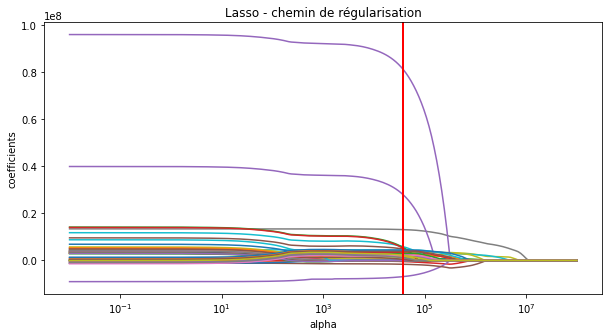

In [37]:
# modelisation sans gridsearch() pour voir l'effet sur les coeff

n_alphas = 200
alphas = np.logspace(-2, 8, n_alphas)
lasso_regression = Lasso(fit_intercept=False)

coefs = []
errors = []
for a in alphas:
    lasso_regression.set_params(alpha=a)
    lasso_regression.fit(X_train, y_train)
    coefs.append(lasso_regression.coef_.flatten())
    errors.append(np.mean((lasso_regression.predict(X_val) - y_val) ** 2))
    
# Affiche le chemin de régularisation
alpha_min = alphas[np.argmin(errors)]
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(alphas, coefs)

plt.axvline(x=alpha_min,linewidth=2, color='r')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title('Lasso - chemin de régularisation')
plt.axis('tight')
plt.show()

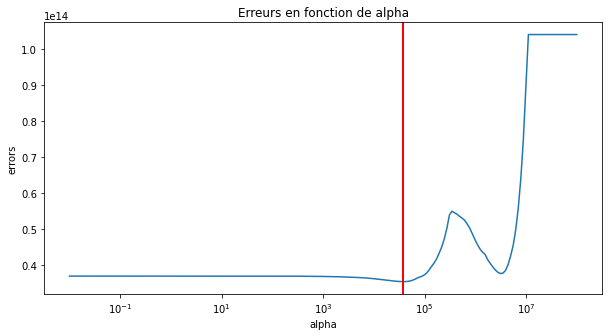

In [38]:
# Affiche la courbe d'erreurs en fonction de la régularisation
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(alphas, errors)

plt.axvline(x=alpha_min,linewidth=2, color='r')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('errors')
plt.title('Erreurs en fonction de alpha')
plt.axis('tight')
plt.show()

**4) régression elasticnet**

In [39]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

elasticnet_regression = ElasticNet()

n_alphas = 100
alpha = np.logspace(-2, 8, n_alphas)
l1_ratio = np.arange(0.1,1,0.1)
max_iter = [10000]


hyperparameters = dict(alpha=alpha, l1_ratio=l1_ratio , max_iter=max_iter)

gscv_elasticnet_regression = GridSearchCV(elasticnet_regression, hyperparameters, cv=KFold(5,shuffle=True, random_state=random_state), scoring=scoring)

gscv_elasticnet_regression.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=99, shuffle=True),
             estimator=ElasticNet(),
             param_grid={'alpha': array([1.00000000e-02, 1.26185688e-02, 1.59228279e-02, 2.00923300e-02,
       2.53536449e-02, 3.19926714e-02, 4.03701726e-02, 5.09413801e-02,
       6.42807312e-02, 8.11130831e-02, 1.02353102e-01, 1.29154967e-01,
       1.62975083e-01, 2.05651231e-01, 2.59502421e-01, 3.27454916e-...
       3.05385551e+06, 3.85352859e+06, 4.86260158e+06, 6.13590727e+06,
       7.74263683e+06, 9.77009957e+06, 1.23284674e+07, 1.55567614e+07,
       1.96304065e+07, 2.47707636e+07, 3.12571585e+07, 3.94420606e+07,
       4.97702356e+07, 6.28029144e+07, 7.92482898e+07, 1.00000000e+08]),
                         'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_iter': [10000]},
             scoring='neg_root_mean_squared_error')

In [40]:
print('coefficients: ', gscv_elasticnet_regression.best_estimator_.coef_.flatten())
print('alpha: ', gscv_elasticnet_regression.best_estimator_.get_params()['alpha'])
print('l1_ratio: ', gscv_elasticnet_regression.best_estimator_.get_params()['l1_ratio'])
print('max_iter: ', gscv_elasticnet_regression.best_estimator_.get_params()['max_iter'])
print('tol: ', gscv_elasticnet_regression.best_estimator_.get_params()['tol'])
print('score moyen RMSE sur cv: ', -gscv_elasticnet_regression.best_score_)

y_pred_val = gscv_elasticnet_regression.predict(X_val)
regression_report = regression_report.append(get_metrics(y_val, y_pred_val, 'gscv_elasticnet_regression_on_val'))

coefficients:  [ 5.63906760e+04 -2.48854720e+05  4.87654280e+05 -5.09016609e+05
 -3.73955657e+06 -2.73971600e+06 -3.60069893e+06  1.42513748e+07
  3.81749198e+06  4.25799423e+06  5.63898094e+04 -5.36266242e+06
 -5.78714743e+06 -6.58975697e+06  6.05433337e+07 -3.71194507e+05
 -5.76749466e+06 -6.70271578e+06 -5.60398230e+06  1.64805601e+06
 -6.31468078e+06 -5.72493840e+06 -6.49207638e+06 -1.68464021e+06
  2.31748522e+07 -3.65019191e+06 -4.93371311e+06 -4.13156243e+06
 -4.23151988e+06 -2.08432292e+05 -3.07528692e+06 -4.37915252e+06
  3.59335681e+06  3.36208951e+06 -6.55282124e+06 -4.75758315e+06
 -7.54234664e+05  3.45551157e+05  1.12912260e+05  1.67185704e+05
  1.43015184e+06  1.99842807e+05  6.52814276e+04  1.12935220e+05
 -6.10034243e+05  7.81021830e+05 -1.07121155e+06 -9.86544508e+05
  2.07097719e+05]
alpha:  0.012618568830660204
l1_ratio:  0.9
max_iter:  10000
tol:  0.0001
score moyen RMSE sur cv:  11231300.87120566


In [41]:
y_pred_train = gscv_elasticnet_regression.predict(X_train)
regression_report = regression_report.append(get_metrics(y_train, y_pred_train, 'gscv_elasticnet_regression_on_train'))

**5) support vector regression**

In [42]:
from sklearn.svm import SVR

svr = SVR()


n_gammas = 8
gamma = np.logspace(-8, 10, n_gammas)

n_epsilons = 5
epsilon = np.logspace(-3, 1, n_epsilons)

n_C = 5
C = np.logspace(-3, 2, n_C)


hyperparameters = dict(gamma=gamma, epsilon=epsilon , C=C)

gscv_svr = GridSearchCV(svr, hyperparameters, cv=KFold(5,shuffle=True, random_state=random_state), scoring=scoring)

gscv_svr.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=99, shuffle=True),
             estimator=SVR(),
             param_grid={'C': array([1.00000000e-03, 1.77827941e-02, 3.16227766e-01, 5.62341325e+00,
       1.00000000e+02]),
                         'epsilon': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                         'gamma': array([1.00000000e-08, 3.72759372e-06, 1.38949549e-03, 5.17947468e-01,
       1.93069773e+02, 7.19685673e+04, 2.68269580e+07, 1.00000000e+10])},
             scoring='neg_root_mean_squared_error')

In [43]:
y_pred_val = gscv_svr.predict(X_val)
regression_report = regression_report.append(get_metrics(y_val, y_pred_val, 'gscv_svr_on_val'))

In [44]:
y_pred_train = gscv_svr.predict(X_train)
regression_report = regression_report.append(get_metrics(y_train, y_pred_train, 'gscv_svr_on_train'))

**6) random forest regressor**

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rfr = RandomForestRegressor()

n_estimators = [100,200,300]
#max_depth = [5,15,30,45]
max_depth = [None]
min_samples_leaf = [1,3,5,10]
max_features = ['auto', 'sqrt']

hyperparameters = dict(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf , max_features=max_features , max_depth=max_depth)

gscv_rfr = GridSearchCV(rfr, hyperparameters, cv=KFold(5,shuffle=True, random_state=random_state), scoring=scoring)

gscv_rfr.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=99, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None], 'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error')

In [46]:
print('score moyen RMSE sur cv: ', -gscv_rfr.best_score_)
print('cv_results_: ', gscv_rfr.cv_results_)
print('best_params_: ', gscv_rfr.best_params_)

score moyen RMSE sur cv:  6531795.249432868
cv_results_:  {'mean_fit_time': array([1.8597085 , 3.67548962, 5.55958409, 1.46005244, 2.9108232 ,
       4.36447387, 1.30132074, 2.58980918, 3.89430757, 1.06665211,
       2.12400618, 3.19318552, 0.47691941, 0.96456742, 1.44947095,
       0.32836084, 0.67145362, 1.00742555, 0.30202928, 0.6046804 ,
       0.88064218, 0.26156306, 0.52631707, 0.79513741]), 'std_fit_time': array([0.03230839, 0.07999674, 0.11201218, 0.03503924, 0.05386461,
       0.0781324 , 0.02042142, 0.04798979, 0.0741596 , 0.02924931,
       0.06166331, 0.08072589, 0.00576116, 0.00741626, 0.02112883,
       0.00135174, 0.01158827, 0.01437178, 0.0073194 , 0.0150266 ,
       0.00601373, 0.00314827, 0.00776018, 0.02449438]), 'mean_score_time': array([0.0187057 , 0.03553004, 0.05193009, 0.01441288, 0.02742419,
       0.03960376, 0.0131546 , 0.02441549, 0.03603215, 0.01111088,
       0.0209548 , 0.03091125, 0.01763725, 0.03442717, 0.05104036,
       0.01319933, 0.02500939, 0.03729

In [47]:
X_val.shape

(480, 49)

In [48]:
y_pred_val = gscv_rfr.predict(X_val)
regression_report = regression_report.append(get_metrics(y_val, y_pred_val, 'gscv_rfr_on_val'))

In [49]:
y_pred_train = gscv_rfr.predict(X_train)
regression_report = regression_report.append(get_metrics(y_train, y_pred_train, 'gscv_rfr_on_train'))

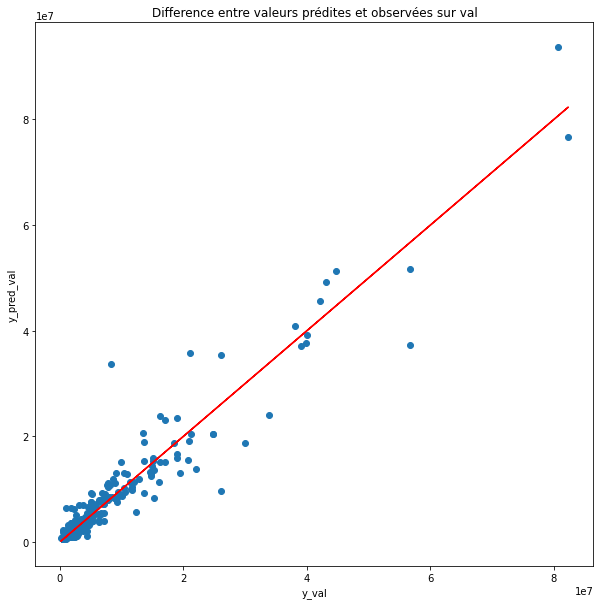

In [50]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(y_val, y_pred_val)
ax.plot(y_val, y_val, 'r')
plt.xlabel('y_val')
plt.ylabel('y_pred_val')
plt.title('Difference entre valeurs prédites et observées sur val')

plt.show()

___
### Evaluation / Comparaison des modèles
___

**Rapport de regression**

<AxesSubplot:title={'center':'Train - Rapport de regression'}>

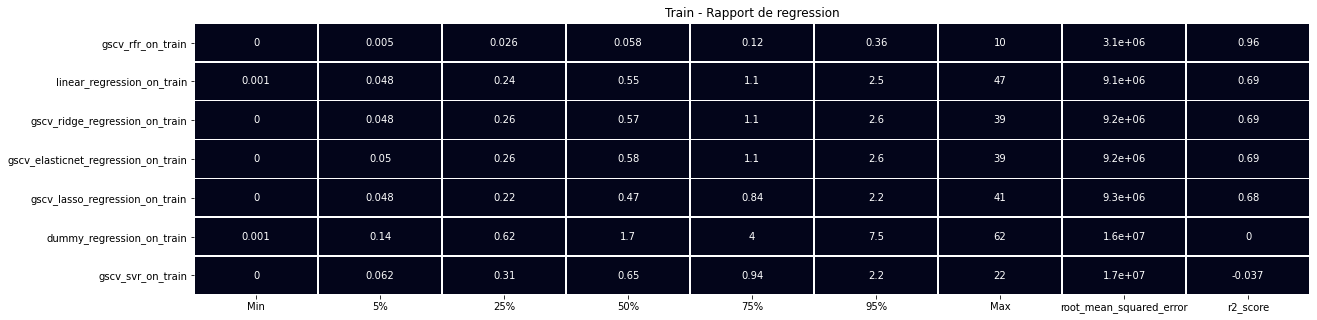

In [51]:
rr = regression_report[regression_report.index.str.contains('train$')].sort_values(by=['r2_score'], ascending=False)
fig, ax = plt.subplots(figsize=(20,5))
plt.title('Train - Rapport de regression')
sns.heatmap(rr,vmin=regression_report.max().Max,vmax=regression_report.max().Max, annot=True, cbar=None,linewidths=.5)

<AxesSubplot:title={'center':'Val - Rapport de regression'}>

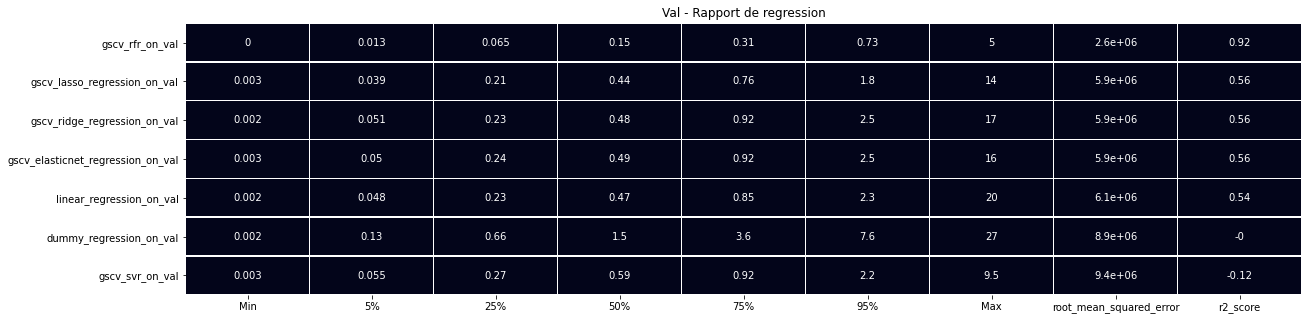

In [52]:
rr = regression_report[regression_report.index.str.contains('val$')].sort_values(by=['r2_score'], ascending=False)
fig, ax = plt.subplots(figsize=(20,5))
plt.title('Val - Rapport de regression')
sns.heatmap(rr,vmin=regression_report.max().Max,vmax=regression_report.max().Max, annot=True, cbar=None,linewidths=.5)

**Analyse des erreurs**

In [ ]:
df_errors_val = get_errors(y_val,y_pred_val)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim([-5,5 ])
ax.hist(df_errors_val['errors_normalized'], bins=500, density=True)

plt.title('Histogramme erreurs normalisées')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(y_val, df_errors_val['errors'])
plt.xlabel('y_val')
plt.ylabel('errors')
plt.title('Erreurs')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(y_val, df_errors_val['errors_relative'])
plt.xlabel('y_val')
plt.ylabel('errors_relative')
plt.title('Erreurs relatives')

plt.show()

**Contraintes**

Temps d'execution : Inconnu   
Capacité de stockage : Inconnu

### Optimisation secondaire du meilleur modèle

Correlation et importance des variables dans les forets aléatoires

>Des simulations numériques confirment
d’une part les résultats theoriques et indiquent d’autre part que l’algorithme RFE tend a
selectionner un faible nombre de variables avec une bonne erreur de prédiction.

B.Gregorutti, B.Michel, P Saint-Pierre *Correlation et importance des variables dans les forets aléatoires* @Univ. Pierre et Marie Curie [source](http://papersjds14.sfds.asso.fr/submission_48.pdf)

**selection Recursive feature elimination**

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

n_features_max = X_train.shape[1]          
high_score=0

best_n=0           
score_list =[]
for n in range(1,n_features_max):
    best_estimator = gscv_rfr.best_estimator_
    rfe = RFE(best_estimator, n_features_to_select = n)
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    scores = cross_val_score(best_estimator, X_train_rfe, y_train, cv=5,scoring='r2')
    score = np.mean(scores)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        best_n = n
        
print(f"Optimum number of features: {best_n}")
print(f"Score with {best_n} features: {high_score}")

In [ ]:
best_rfe = RFE(best_estimator, n_features_to_select = best_n)
X_train_rfe = best_rfe.fit_transform(X_train,y_train)
X_val_rfe = best_rfe.transform(X_val)
X_test_rfe = best_rfe.transform(X_test)
best_estimator.fit(X_train_rfe,y_train)

In [ ]:
X_val_rfe.shape

In [ ]:
y_pred_val = best_estimator.predict(X_val_rfe)
regression_report = regression_report.append(get_metrics(y_val, y_pred_val, 'best_estimator_rfe_on_val'))

In [ ]:
y_pred_train = best_estimator.predict(X_train_rfe)
regression_report = regression_report.append(get_metrics(y_train, y_pred_train, 'best_estimator_rfe_on_train'))

In [ ]:
rr = regression_report[regression_report.index.str.contains('val$')].sort_values(by=['r2_score'], ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
plt.title('Val - Rapport de regression avec RFE')
sns.heatmap(rr,vmin=regression_report.max().Max,vmax=regression_report.max().Max, annot=True, cbar=None,linewidths=.5)

In [ ]:
regression_report[regression_report.index.str.contains('train$')].sort_values(by=['r2_score'], ascending=False)

In [ ]:
rr = regression_report[regression_report.index.str.contains('train$')].sort_values(by=['r2_score'], ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
plt.title('Train - Rapport de regression avec RFE')
sns.heatmap(rr,vmin=regression_report.max().Max,vmax=regression_report.max().Max, annot=True, cbar=None,linewidths=.5)